#Uber data analysis from NYC

We have 12 files in parquet format with each file corresponding to data from a specific month, such as January, February, and so on. Each file is approximately 300 MB in size, resulting in a total file size of around 3.6 GB. 

Initially, we imported the data from each individual file. Then, we merged them into a single DataFrame using the 'union' operation.

In [0]:
from pyspark.sql.functions import hour, avg
from pyspark.sql.functions import month, count, round, sum
from pyspark.sql.window import Window

In [0]:
# File location and type
file_locations = [f"/FileStore/fhvhv_tripdata_2021_{str(month).zfill(2)}.parquet" for month in range(1, 13)]
file_type = 'parquet'

# Reading each file
dfs = []
for file_location in file_locations:
    dfs.append(spark.read.parquet(file_location, header=True, inferSchema=True))

# Assigning each DataFrame to a variable
df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12 = dfs

In [0]:
 # Displaying the DataFrame without truncating the column contents
 df_1.show(truncate=False)

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|request_datetime   |on_scene_datetime  |pickup_datetime    |dropoff_datetime   |PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|bcf |sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

In [0]:
#no. of rows, columns in dataframe
print((df_1.count(), len(df_1.columns)))

(11908468, 24)


shape of the dataframe is 11908468 rows and 24 columns

In [0]:
# combining all the 12 datasets into one dataframe
# we created a dataframe with the data of one year.
df=df_1.union(df_2).union(df_3).union(df_4).union(df_5).union(df_6).union(df_7).union(df_8).union(df_9).union(df_10).union(df_11).union(df_12)

In [0]:
# Showing combined dataframe with rows from all the 12 datasets
df.show()

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

In [0]:
#printing the total rows and columns of dataframe
print((df.count(), len(df.columns)))

(174596652, 24)


In [0]:
df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_f

In [0]:
#dropping the null values
df=df.na.drop() 

#Number of users requesting Wheelchair accessible vehicle

+----------------+---------+
|wav_request_flag|    count|
+----------------+---------+
|               Y|   248036|
|               N|125919126|
+----------------+---------+



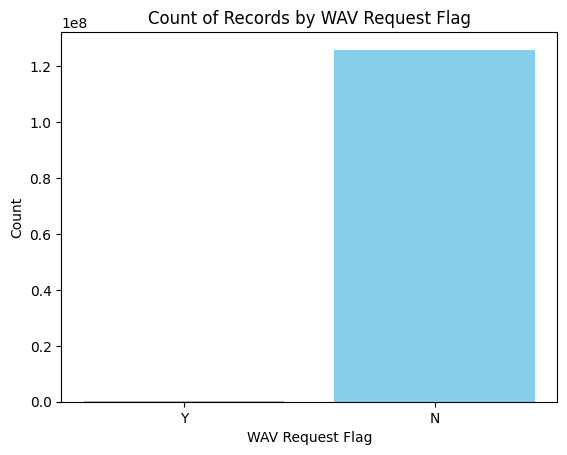

In [0]:
df.groupBy('wav_request_flag').count().show()

import matplotlib.pyplot as plt
# Grouping the DataFrame by 'wav_request_flag' and counting the occurrences
grouped_df = df.groupBy('wav_request_flag').count().toPandas()
# Plotting the bar chart
plt.bar(grouped_df['wav_request_flag'], grouped_df['count'], color='skyblue')
plt.xlabel('WAV Request Flag')
plt.ylabel('Count')
plt.title('Count of Records by WAV Request Flag')
plt.show()

#Number of rides requested on hourly basis

In [0]:
#grouping the dataframe by hour
df.groupBy(hour("request_datetime")).count().show()

+----------------------+-------+
|hour(request_datetime)|  count|
+----------------------+-------+
|                    12|5869616|
|                    22|6387803|
|                     1|3099535|
|                    13|6117938|
|                     6|3271702|
|                    16|6974141|
|                     3|1681608|
|                    20|6844411|
|                     5|1994045|
|                    19|7496242|
|                    15|6788535|
|                     9|5687087|
|                    17|7453609|
|                     4|1524203|
|                     8|5877271|
|                    23|5623193|
|                     7|4890719|
|                    10|5530855|
|                    21|6520177|
|                    11|5647041|
+----------------------+-------+
only showing top 20 rows



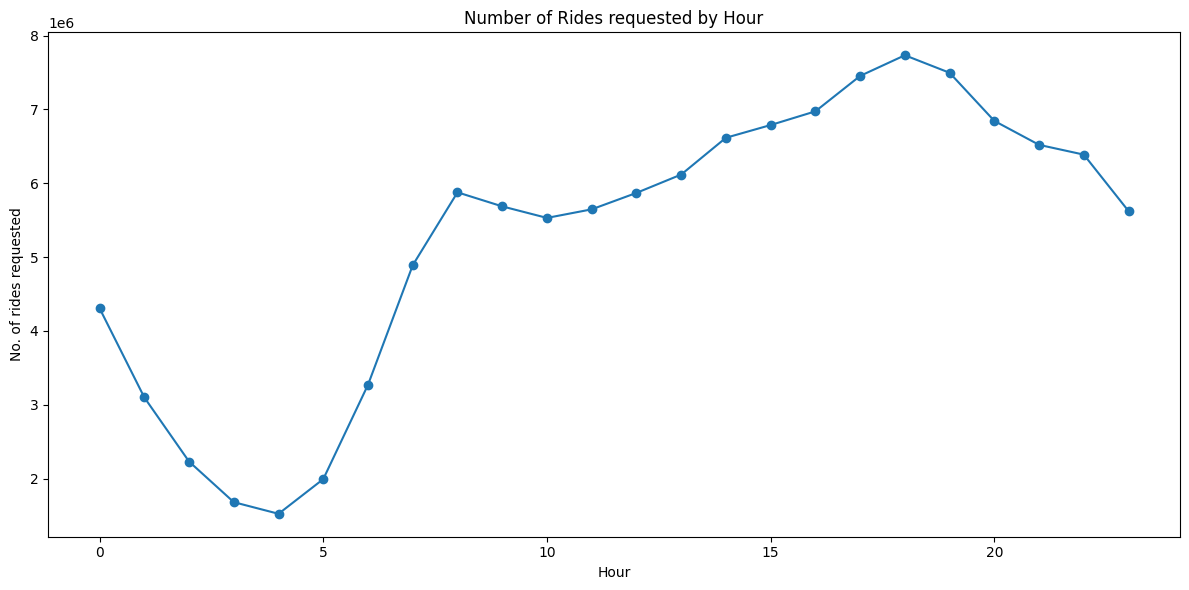

In [0]:
import matplotlib.pyplot as plt
# Grouping the rows by hour and counting the number of rows in each hour
count_df = df.groupBy(hour("request_datetime").alias("hour")).agg(count("*").alias("count"))
# Converting the PySpark DataFrame to a Pandas DataFrame and sorting by hour
pandas_df = count_df.toPandas().sort_values("hour")

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(pandas_df["hour"], pandas_df["count"], marker='o')
plt.title("Number of Rides requested by Hour")
plt.xlabel("Hour")
plt.ylabel("No. of rides requested")
plt.tight_layout()
plt.show()

#Number of rides requested on monthly basis

In [0]:
# grouping the rows by month and counting the number of rows in each month
df.groupBy(month("request_datetime").alias("month")).agg(count("*").alias("count")).show()

+-----+--------+
|month|   count|
+-----+--------+
|   12|11804976|
|    1| 8703005|
|    2| 8294779|
|    3|10174239|
|    4|10243004|
|    5|10812106|
|    6|10751250|
|    7|10709523|
|    8|10199226|
|    9|10561787|
|   10|12090988|
|   11|11822279|
+-----+--------+



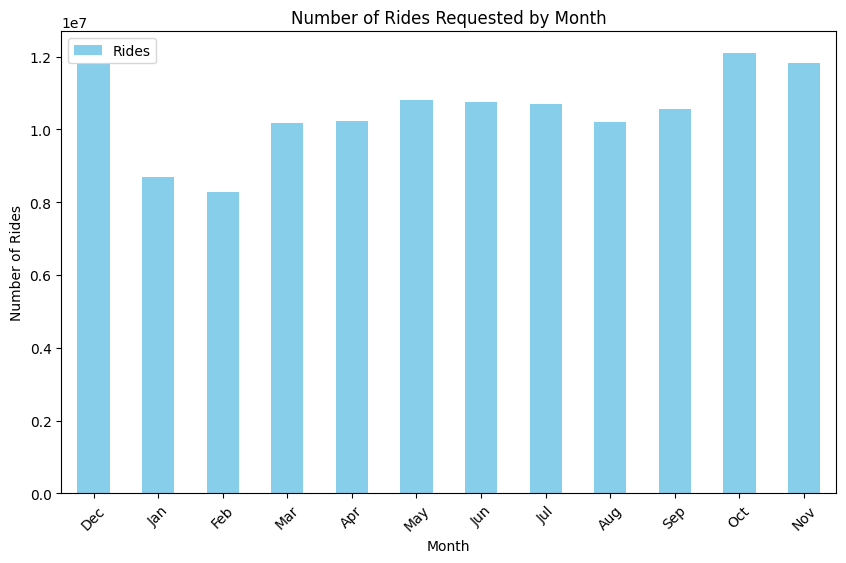

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import calendar  

# Grouping by month and counting the number of rows
count_df = df.groupBy(month("request_datetime").alias("month")).count()

# Converting to Pandas DataFrame and renaming columns
pandas_df = count_df.toPandas().rename(columns={"month": "Month", "count": "Rides"})

# Mapping month numbers to names
pandas_df["Month"] = pandas_df["Month"].map(lambda x: calendar.month_abbr[x])

# Plotting
pandas_df.plot(kind="bar", x="Month", y="Rides", color="#87CEEB", figsize=(10, 6))
plt.title("Number of Rides Requested by Month")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)
plt.show()

#Season wise requested rides

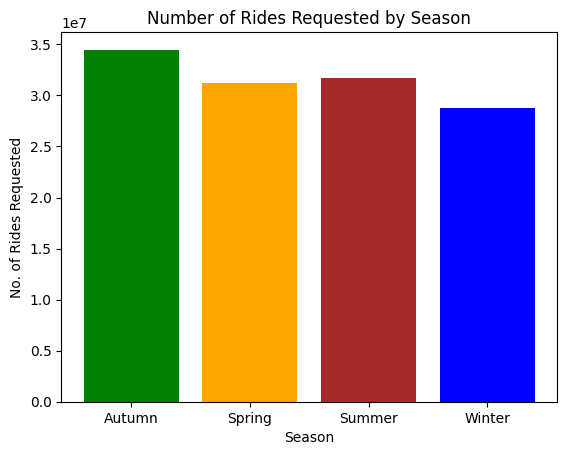

In [0]:
from pyspark.sql.functions import month, udf, col
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt

# Define a UDF to map month to season
season_mapping = {
    1: "Winter",
    2: "Winter",
    3: "Spring",
    4: "Spring",
    5: "Spring",
    6: "Summer",
    7: "Summer",
    8: "Summer",
    9: "Autumn",
    10: "Autumn",
    11: "Autumn",
    12: "Winter"
}
get_season = udf(lambda month: season_mapping[month], StringType())

# Add a new column for season
df_with_season = df.withColumn("season", get_season(month("request_datetime")))

# Group by season and count the number of rides in each season
count_df = df_with_season.groupBy("season").count().orderBy("season")

# Convert to Pandas DataFrame
pandas_df = count_df.toPandas()

# Define the order of seasons for plotting
season_order = ["Spring", "Summer", "Autumn", "Winter"]

# Plotting the bar chart
plt.bar(pandas_df["season"], pandas_df["count"], color=["green", "orange", "brown", "blue"])
plt.title("Number of Rides Requested by Season")
plt.xlabel("Season")
plt.ylabel("No. of Rides Requested")
plt.xticks(season_order)
plt.show()


#October is the month and Autumn is the season with highest number of rides

#Average trip time month wise

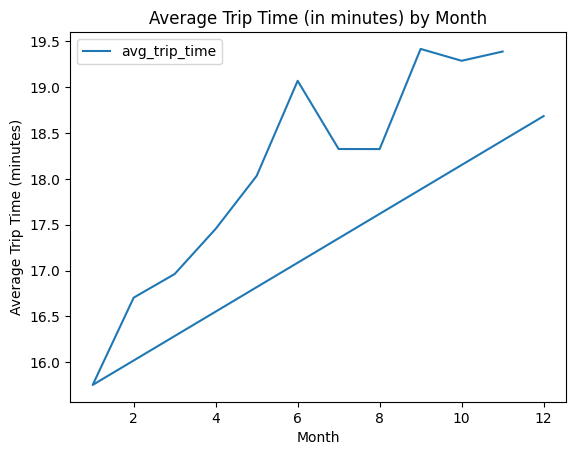

In [0]:
# Grouping the rows by month and calculating the average trip time
avg_time_df = df.groupBy(month("request_datetime").alias("month")).agg(avg("trip_time").alias("avg_trip_time"))

# Converting average trip time from seconds to minutes
pandas_df = avg_time_df.toPandas()
pandas_df['avg_trip_time'] = pandas_df['avg_trip_time'] / 60

# Plotting the data
ax = pandas_df.plot(x="month", y="avg_trip_time", kind="line")
ax.set_xlabel("Month")
ax.set_ylabel("Average Trip Time (minutes)")
ax.set_title("Average Trip Time (in minutes) by Month")
plt.show()


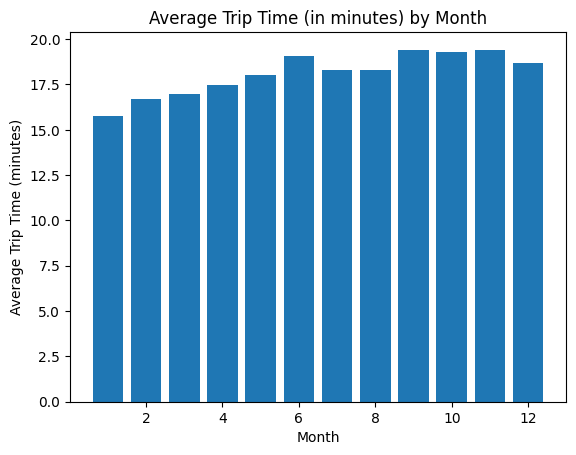

In [0]:
# Grouping the rows by month and calculating the average trip time
avg_time_df = df.groupBy(month("request_datetime").alias("month")).agg(avg("trip_time").alias("avg_trip_time"))

# Converting average trip time from seconds to minutes
pandas_df = avg_time_df.toPandas()
pandas_df['avg_trip_time'] = pandas_df['avg_trip_time'] / 60

# Plotting the data
plt.bar(pandas_df["month"], pandas_df["avg_trip_time"])
plt.title("Average Trip Time (in minutes) by Month")
plt.xlabel("Month")
plt.ylabel("Average Trip Time (minutes)")
plt.show()


#Average trip miles month wise

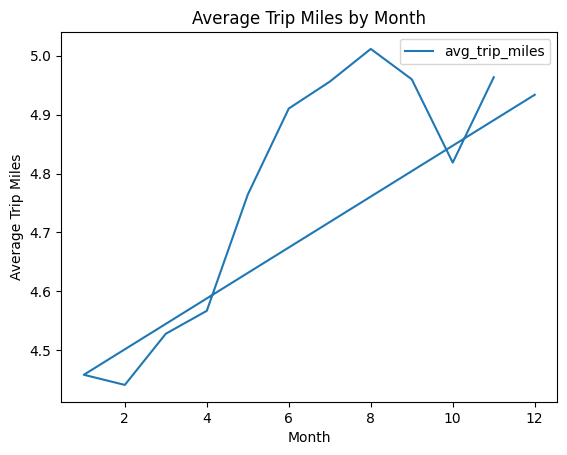

In [0]:
# grouping the rows by month and calculating the average trip time
avg_time_df = df.groupBy(month("request_datetime").alias("month")).agg(avg("trip_miles").alias("avg_trip_miles"))
pandas_df = avg_time_df.toPandas()

# plotting the line graph
ax = pandas_df.plot(x="month", y="avg_trip_miles", kind="line")
ax.set_xlabel("Month")
ax.set_ylabel("Average Trip Miles")
ax.set_title("Average Trip Miles by Month")
plt.show()

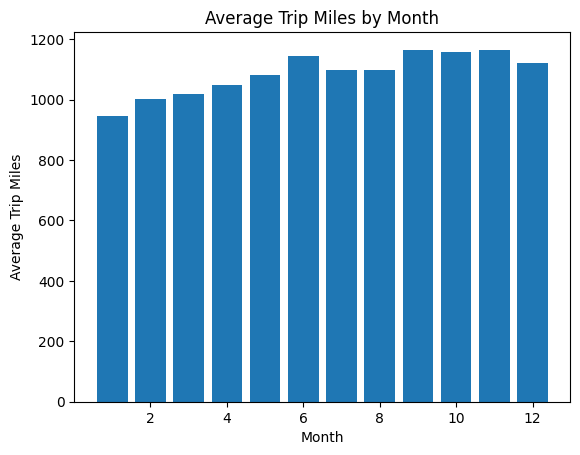

In [0]:
# grouping the rows by month and calculatting the average trip time
avg_time_df = df.groupBy(month("request_datetime").alias("month")).agg(avg("trip_time").alias("avg_trip_miles"))
pandas_df = avg_time_df.toPandas()

# plotting the bar chart
plt.bar(pandas_df["month"], pandas_df["avg_trip_miles"])
plt.title("Average Trip Miles by Month")
plt.xlabel("Month")
plt.ylabel("Average Trip Miles")
plt.show()

#Analysing the Company delay

Examining the Time Gap Between Ride Request and Arrival

- Analyzing the delay on an hourly basis

- Segmenting by Dispatching Base Number to assess variations.

In [0]:
from pyspark.sql.functions import col, expr

hourly_delay_df = df.withColumn("company_delay", expr("on_scene_datetime - request_datetime")) \
    .groupBy(hour("request_datetime").alias("hour")) \
    .agg(avg("company_delay").alias("avg_company_delay"))

hourly_delay_df.show()

+----+--------------------+
|hour|   avg_company_delay|
+----+--------------------+
|  12|INTERVAL '0 00:04...|
|  22|INTERVAL '0 00:04...|
|   1|INTERVAL '0 00:04...|
|  13|INTERVAL '0 00:04...|
|   6|INTERVAL '0 00:04...|
|  16|INTERVAL '0 00:04...|
|   3|INTERVAL '0 00:04...|
|  20|INTERVAL '0 00:04...|
|   5|INTERVAL '0 00:04...|
|  19|INTERVAL '0 00:04...|
|  15|INTERVAL '0 00:04...|
|   9|INTERVAL '0 00:03...|
|  17|INTERVAL '0 00:04...|
|   4|INTERVAL '0 00:05...|
|   8|INTERVAL '0 00:04...|
|  23|INTERVAL '0 00:05...|
|   7|INTERVAL '0 00:04...|
|  10|INTERVAL '0 00:03...|
|  21|INTERVAL '0 00:04...|
|  11|INTERVAL '0 00:03...|
+----+--------------------+
only showing top 20 rows



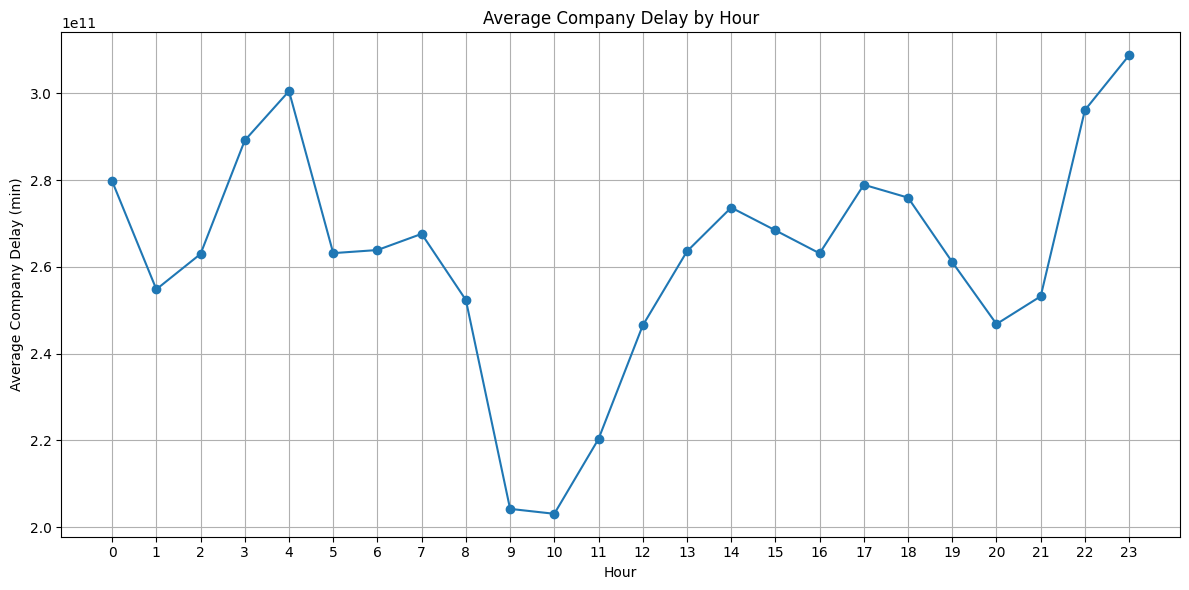

In [0]:
# Convert PySpark DataFrame to Pandas DataFrame and sort values
pandas_hourly_delay_df = hourly_delay_df.toPandas().sort_values("hour")

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(pandas_hourly_delay_df["hour"], pandas_hourly_delay_df["avg_company_delay"], marker="o", linestyle="-")
plt.title("Average Company Delay by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Company Delay (min)")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


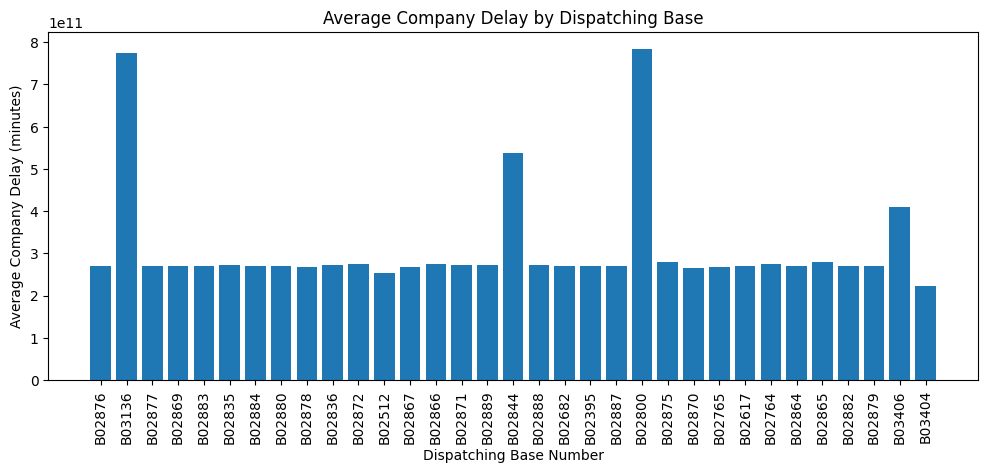

In [0]:
# Grouping the DataFrame by dispatching_base_num and calculating average company delay
dispatching_base_delay_df = df.withColumn("company_delay", expr("on_scene_datetime - request_datetime")) \
    .groupBy("dispatching_base_num") \
    .agg(avg("company_delay").alias("avg_company_delay"))

# Convert to Pandas DataFrame
pandas_dispatching_base_delay_df = dispatching_base_delay_df.toPandas()

# Plotting the data
plt.figure(figsize=(12, 6))
plt.bar(pandas_dispatching_base_delay_df["dispatching_base_num"], pandas_dispatching_base_delay_df["avg_company_delay"])
plt.title("Average Company Delay by Dispatching Base")
plt.xlabel("Dispatching Base Number")
plt.ylabel("Average Company Delay (minutes)")
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
ax.margins(y=0.1)
plt.show()


#Analyzing Customer Delay

Examining the Time Gap Between Driver Arrival and Ride Start

- Analysis by Hour

- Segmentation by Dispatching Base Number

In [0]:
from pyspark.sql.functions import col, expr

hourly_customer_delay_df = df.withColumn("customer_delay", expr("pickup_datetime - on_scene_datetime")) \
    .groupBy(hour("pickup_datetime").alias("hour")) \
    .agg(avg("customer_delay").alias("avg_customer_delay"))

hourly_customer_delay_df.show()

+----+--------------------+
|hour|  avg_customer_delay|
+----+--------------------+
|  12|INTERVAL '0 00:00...|
|  22|INTERVAL '0 00:00...|
|   1|INTERVAL '0 00:01...|
|  13|INTERVAL '0 00:00...|
|   6|INTERVAL '0 00:01...|
|  16|INTERVAL '0 00:00...|
|   3|INTERVAL '0 00:01...|
|  20|INTERVAL '0 00:01...|
|   5|INTERVAL '0 00:01...|
|  19|INTERVAL '0 00:00...|
|  15|INTERVAL '0 00:00...|
|   9|INTERVAL '0 00:01...|
|  17|INTERVAL '0 00:00...|
|   4|INTERVAL '0 00:01...|
|   8|INTERVAL '0 00:00...|
|  23|INTERVAL '0 00:00...|
|   7|INTERVAL '0 00:00...|
|  10|INTERVAL '0 00:01...|
|  21|INTERVAL '0 00:01...|
|  11|INTERVAL '0 00:00...|
+----+--------------------+
only showing top 20 rows



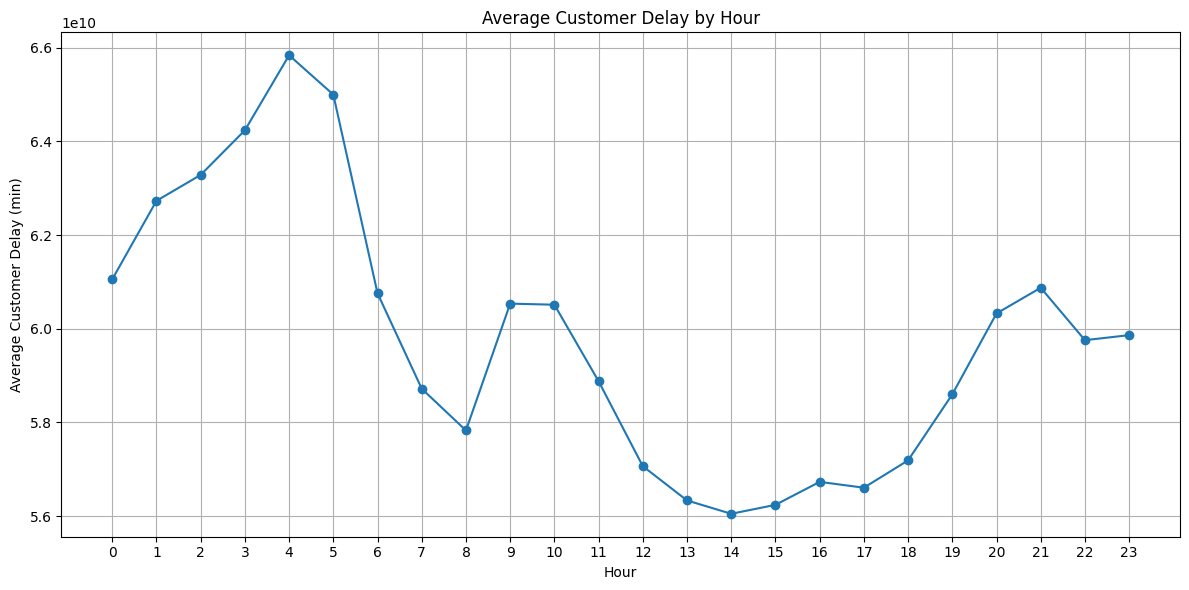

In [0]:
# Converting PySpark DataFrame to Pandas DataFrame and sort values
pandas_hourly_customer_delay_df = hourly_customer_delay_df.toPandas().sort_values("hour")

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(pandas_hourly_customer_delay_df["hour"], pandas_hourly_customer_delay_df["avg_customer_delay"], marker="o", linestyle="-")
plt.title("Average Customer Delay by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Customer Delay (min)")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
import matplotlib.pyplot as plt

# Grouping the DataFrame by dispatching_base_num and calculating average customer delay
dispatching_base_customer_delay_df = df.withColumn("customer_delay", expr("pickup_datetime - on_scene_datetime")) \
    .groupBy("dispatching_base_num") \
    .agg(avg("customer_delay").alias("avg_customer_delay"))
    
dispatching_base_customer_delay_df.show()

+--------------------+--------------------+
|dispatching_base_num|  avg_customer_delay|
+--------------------+--------------------+
|              B02876|INTERVAL '0 00:00...|
|              B03136|INTERVAL '0 00:01...|
|              B02877|INTERVAL '0 00:00...|
|              B02869|INTERVAL '0 00:00...|
|              B02883|INTERVAL '0 00:00...|
|              B02835|INTERVAL '0 00:00...|
|              B02884|INTERVAL '0 00:00...|
|              B02880|INTERVAL '0 00:00...|
|              B02878|INTERVAL '0 00:00...|
|              B02836|INTERVAL '0 00:00...|
|              B02872|INTERVAL '0 00:00...|
|              B02512|INTERVAL '0 00:01...|
|              B02867|INTERVAL '0 00:00...|
|              B02866|INTERVAL '0 00:00...|
|              B02871|INTERVAL '0 00:00...|
|              B02889|INTERVAL '0 00:00...|
|              B02844|INTERVAL '0 00:01...|
|              B02888|INTERVAL '0 00:00...|
|              B02682|INTERVAL '0 00:00...|
|              B02395|INTERVAL '

#Wheel chair accessible vehicles

- Hour wise
- Dispatching base wise

In [0]:
# Filtering the DataFrame to include only WAV (wheelchair-accessible vehicle) requests
wav_hourly_df = df.filter(df["wav_request_flag"] == "Y") \
    .groupBy(hour("request_datetime").alias("hour")) \
    .count()  # Counting the number of requests in each hour

wav_hourly_df.show()

+----+-----+
|hour|count|
+----+-----+
|  12|22647|
|  22| 5840|
|   1| 2441|
|  13|23080|
|   6| 1927|
|  16|16573|
|   3| 1168|
|  20| 8227|
|   5| 1327|
|  19| 9701|
|  15|19625|
|   9|15609|
|  17|14425|
|   4| 1006|
|   8| 9948|
|  23| 4533|
|   7| 4604|
|  10|18886|
|  21| 7413|
|  11|19985|
+----+-----+
only showing top 20 rows



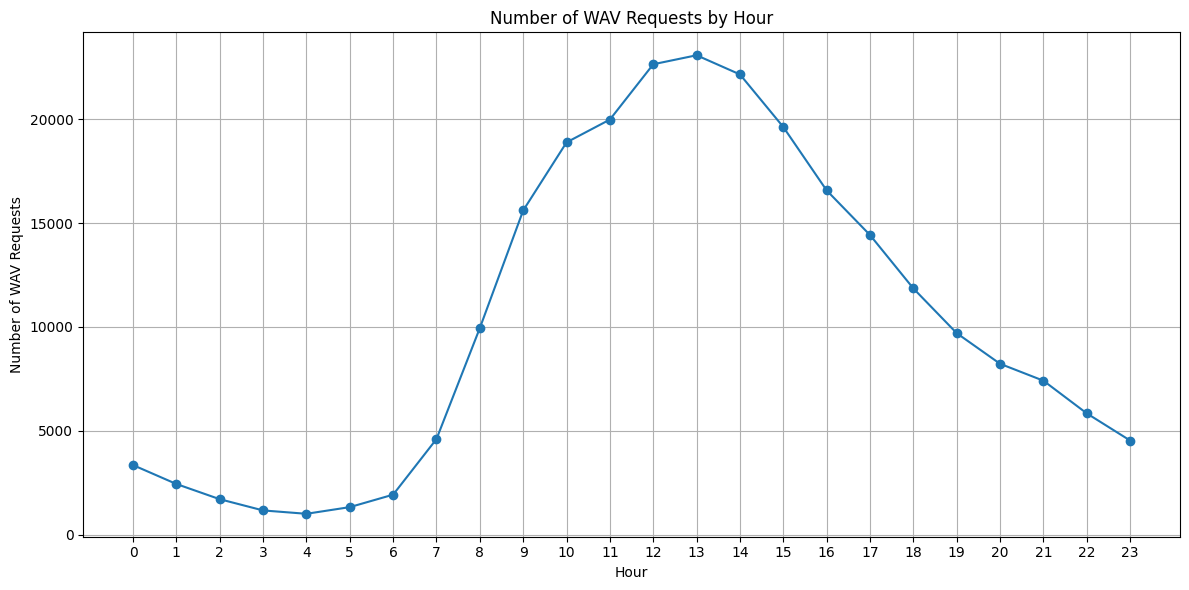

In [0]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_wav_hourly_df = wav_hourly_df.toPandas()
# Sort the DataFrame by hour
pandas_wav_hourly_df = pandas_wav_hourly_df.sort_values("hour")

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(pandas_wav_hourly_df["hour"], pandas_wav_hourly_df["count"], marker="o", linestyle="-")
plt.title("Number of WAV Requests by Hour")
plt.xlabel("Hour")
plt.ylabel("Number of WAV Requests")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
wav_dispatching_base_df = df.filter(df["wav_request_flag"] == "Y") \
    .groupBy("dispatching_base_num") \
    .count()

wav_dispatching_base_df.show()

+--------------------+-----+
|dispatching_base_num|count|
+--------------------+-----+
|              B02876| 1412|
|              B03136| 1350|
|              B02869| 1000|
|              B02883|  307|
|              B02835| 4832|
|              B02884| 1642|
|              B02880|   34|
|              B02878|  952|
|              B02836|  913|
|              B02872|41564|
|              B02512|  125|
|              B02867|  170|
|              B02866| 8776|
|              B02871| 9655|
|              B02889|  164|
|              B02844|37745|
|              B02888|   30|
|              B02682|  629|
|              B02395| 2666|
|              B02887|  142|
+--------------------+-----+
only showing top 20 rows



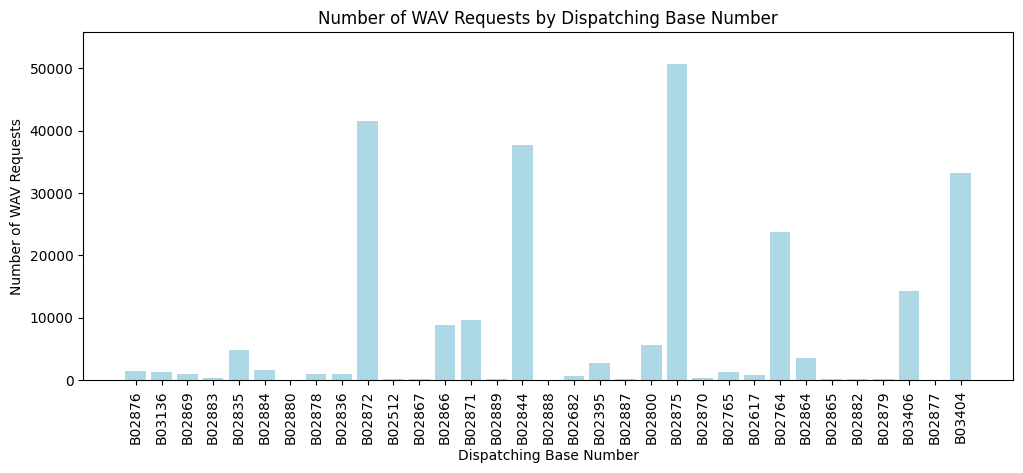

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_wav_dispatching_base_df = wav_dispatching_base_df.toPandas()

# Plotting 
plt.figure(figsize=(12, 6))
plt.bar(pandas_wav_dispatching_base_df["dispatching_base_num"], pandas_wav_dispatching_base_df["count"],
        color="lightblue")
plt.title("Number of WAV Requests by Dispatching Base Number")
plt.xlabel("Dispatching Base Number")
plt.ylabel("Number of WAV Requests")
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.margins(y=0.1)
plt.show()


#Analysing the base which is receiving more ride requests month wise

In [0]:
from pyspark.sql.functions import month

# Grouping the DataFrame by dispatching base number and month of request datetime
monthly_base_requests = df.groupBy("dispatching_base_num", month("request_datetime").alias("month")) \
    .agg({"*": "count"}) \
    .withColumnRenamed("count(1)", "count") \
    .orderBy("month", "count", ascending=False)

# Displaying the DataFrame
monthly_base_requests.show()

+--------------------+-----+--------+
|dispatching_base_num|month|   count|
+--------------------+-----+--------+
|              B03404|   12|11783274|
|              B02764|   12|    7635|
|              B03406|   12|    4283|
|              B02872|   12|    1386|
|              B02880|   12|     739|
|              B02867|   12|     719|
|              B02878|   12|     713|
|              B02877|   12|     680|
|              B02395|   12|     604|
|              B02882|   12|     548|
|              B02835|   12|     539|
|              B02884|   12|     380|
|              B02864|   12|     360|
|              B02879|   12|     359|
|              B02682|   12|     337|
|              B02870|   12|     317|
|              B02765|   12|     290|
|              B02876|   12|     256|
|              B02888|   12|     229|
|              B02889|   12|     224|
+--------------------+-----+--------+
only showing top 20 rows



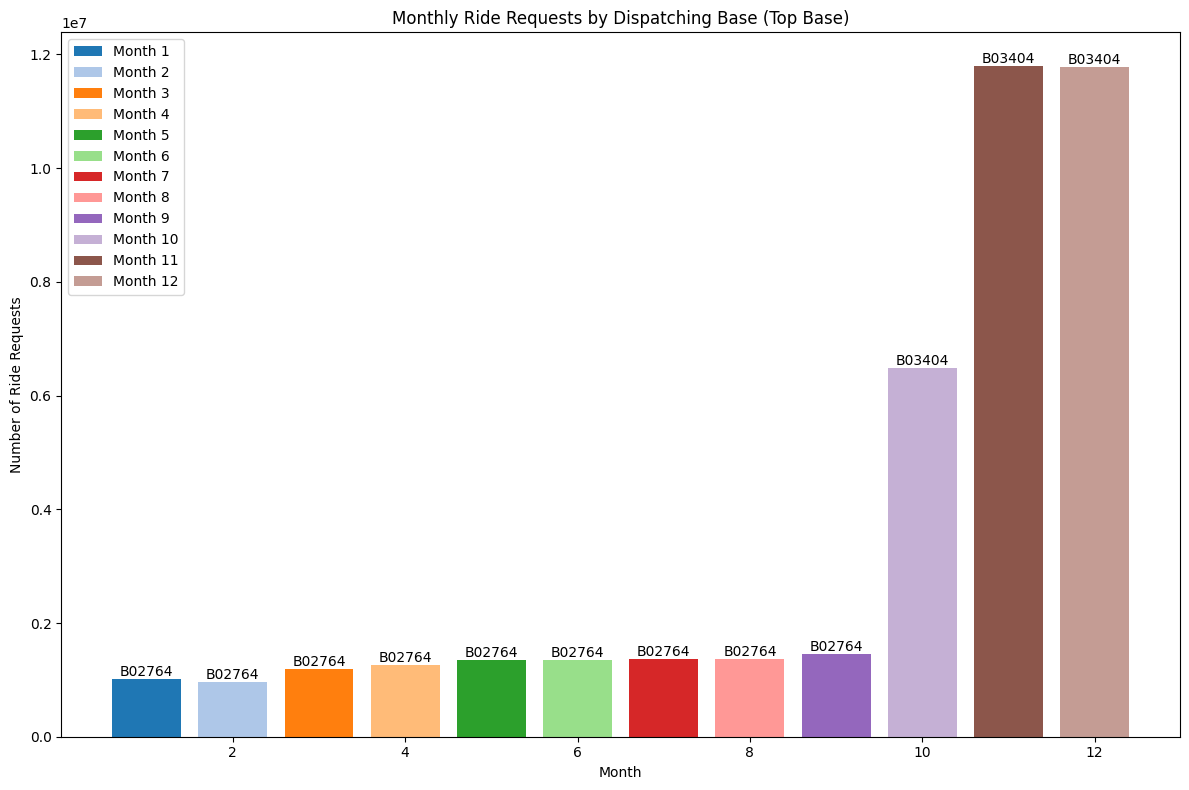

In [0]:
# Converting Spark DataFrame to Pandas DataFrame
monthly_base_requests_pandas = monthly_base_requests.toPandas()
# Grouping the DataFrame by month and getting the base with the maximum count for each month
top_bases = monthly_base_requests_pandas.groupby('month').apply(lambda x: x.loc[x['count'].idxmax()])

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 8))
color_palette = plt.get_cmap('tab20')
for i, (month, base_count) in enumerate(zip(top_bases['month'], top_bases['count'])):
    ax.bar(month, base_count, color=color_palette(i), label=f"Month {month}")
ax.set_xlabel('Month')
ax.set_ylabel('Number of Ride Requests')
ax.set_title('Monthly Ride Requests by Dispatching Base (Top Base)')
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10, top_bases.iloc[i]['dispatching_base_num'],
            ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()

#No. of passengers willing to share vs who actually shared a ride

In [0]:
from pyspark.sql.functions import col
# Calculating the no. of passengers willing to share a ride
willing_to_share_count = df.filter(col("shared_request_flag") == "Y").count()
# Calculating the no.  of passengers who actually shared a ride
actually_shared_count = df.filter(col("shared_match_flag") == "Y").count()
print("Number of passengers willing to share a ride:", willing_to_share_count)
print("Number of passengers who actually shared a ride:", actually_shared_count)

Number of passengers willing to share a ride: 66
Number of passengers who actually shared a ride: 16


/root/.ipykernel/894/command-93080512763266-1081825759:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = cm.get_cmap('tab10')


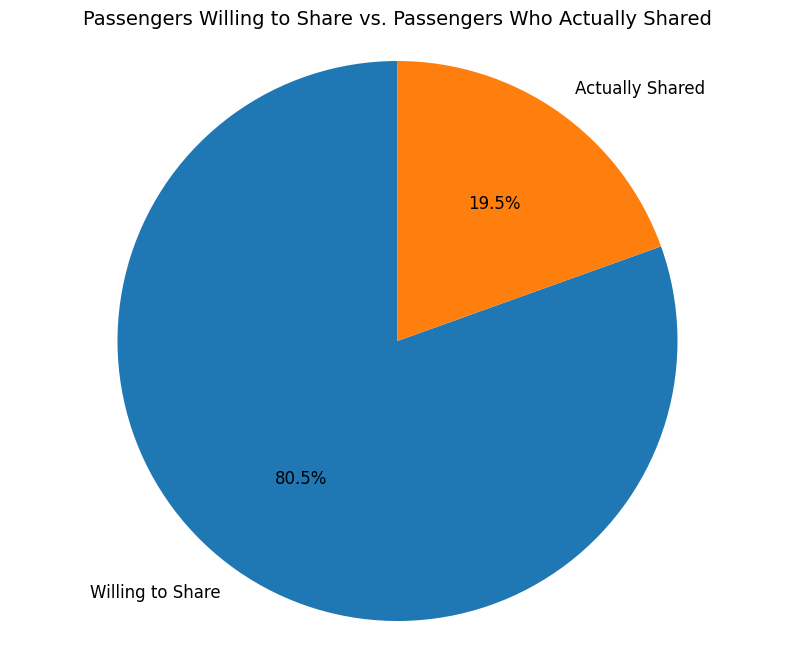

In [0]:
import matplotlib.cm as cm
label_names = ["Willing to Share", "Actually Shared"]
count_values = [willing_to_share_count, actually_shared_count]
# Choosing color palette
color_palette = cm.get_cmap('tab10')
# Creating the pie chart with larger figure size
fig, ax = plt.subplots(figsize=(10, 8))
#plotting
wedges, texts, autotexts = ax.pie(count_values, labels=label_names, autopct='%1.1f%%',
                                  startangle=90, colors=color_palette(range(len(label_names))))
plt.setp(texts + autotexts, size=12)
ax.set_title("Passengers Willing to Share vs. Passengers Who Actually Shared", fontsize=14)
ax.axis('equal')
plt.show()

In [0]:
# Grouping the rows by dispatching base number and willing shared requests flag, and count the number of rows
shared_requests_grouped_df = df.groupBy('dispatching_base_num', 'shared_request_flag').count()
# Filtering the DataFrame for willing shared requests
willing_shared_requests_df = shared_requests_grouped_df.filter(shared_requests_grouped_df['shared_request_flag'] == 'Y')
willing_shared_requests_df.show()

+--------------------+-------------------+-----+
|dispatching_base_num|shared_request_flag|count|
+--------------------+-------------------+-----+
|              B02864|                  Y|    1|
|              B02882|                  Y|    1|
|              B02875|                  Y|    2|
|              B02800|                  Y|   51|
|              B03136|                  Y|   11|
+--------------------+-------------------+-----+



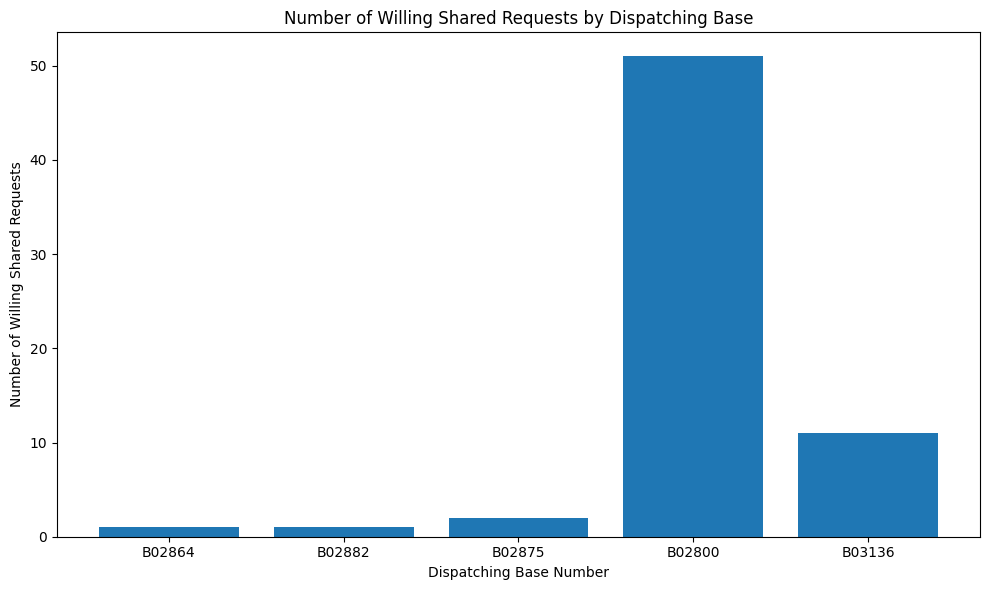

In [0]:
pandas_willing_shared_requests_df = willing_shared_requests_df.toPandas()
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(pandas_willing_shared_requests_df))
ax.bar(x, pandas_willing_shared_requests_df['count'])
ax.set_xlabel("Dispatching Base Number")
ax.set_ylabel("Number of Willing Shared Requests")
ax.set_title("Number of Willing Shared Requests by Dispatching Base")
ax.set_xticks(x)
ax.set_xticklabels(pandas_willing_shared_requests_df['dispatching_base_num'])
# Show the plot
plt.tight_layout()
plt.show()

#Sales of uber by month and base wise

In [0]:
from pyspark.sql.functions import expr

# Register the DataFrame as a temporary view to enable SQL queries
df.createOrReplaceTempView("trip_data")

# Calculate Uber earnings month-wise
monthly_earnings_df = spark.sql("""
    SELECT
        month(request_datetime) AS month,
        dispatching_base_num,
        SUM(base_passenger_fare) AS uber_earnings
    FROM
        trip_data
    GROUP BY
        month,
        dispatching_base_num
    ORDER BY
        month
""")

# Display Uber earnings month-wise
monthly_earnings_df.show()

# Calculate Uber earnings base-wise
base_earnings_df = spark.sql("""
    SELECT
        dispatching_base_num,
        SUM(base_passenger_fare) AS uber_earnings
    FROM
        trip_data
    GROUP BY
        dispatching_base_num
    ORDER BY
        dispatching_base_num
""")

# Display Uber earnings base-wise
base_earnings_df.show()

+-----+--------------------+--------------------+
|month|dispatching_base_num|       uber_earnings|
+-----+--------------------+--------------------+
| NULL|              B02800|               80.62|
|    1|              B02800|  2776536.8800008353|
|    1|              B02764| 1.709558407999919E7|
|    1|              B02887|  5608859.2200040165|
|    1|              B02395|  2057156.0599998052|
|    1|              B02880|  2039273.3599998169|
|    1|              B02512|   849257.9399999768|
|    1|              B02835|  3356147.7900012424|
|    1|              B02871|  5581668.3500040565|
|    1|              B02876|    3930052.36000178|
|    1|              B02865|   1385259.069999935|
|    1|              B02883|   4583129.970002625|
|    1|              B02682|   5457527.990003582|
|    1|              B02864|    5203737.95000335|
|    1|              B02617|   4884974.040003083|
|    1|              B02866|   5285764.480003657|
|    1|              B02877|    3491164.42000131|


In [0]:
from pyspark.sql.functions import month

# Calculating Uber earnings month-wise
monthly_earnings_df = df.groupBy(month("request_datetime").alias("month")) \
                        .agg({"base_passenger_fare": "sum"}) \
                        .withColumnRenamed("sum(base_passenger_fare)", "uber_earnings") \
                        .orderBy("month")

# Displaying Uber earnings month-wise
monthly_earnings_df.show()

# Calculating Uber earnings base-wise
base_earnings_df = df.groupBy("dispatching_base_num") \
                     .agg({"base_passenger_fare": "sum"}) \
                     .withColumnRenamed("sum(base_passenger_fare)", "uber_earnings") \
                     .orderBy("dispatching_base_num")

# Displaying Uber earnings base-wise
base_earnings_df.show()


+-----+--------------------+
|month|       uber_earnings|
+-----+--------------------+
| NULL|               80.62|
|    1|2.0477123632974824E8|
|    2| 2.220180883691697E8|
|    3|2.7993602696070063E8|
|    4| 3.007824368112542E8|
|    5|3.3325991060419565E8|
|    6| 3.558557837430768E8|
|    7|  3.52177398350497E8|
|    8| 3.364052943445495E8|
|    9| 3.576938835453623E8|
|   10|3.7493184828389883E8|
|   11| 3.631421314254459E8|
|   12| 3.581980251870854E8|
+-----+--------------------+

+--------------------+--------------------+
|dispatching_base_num|       uber_earnings|
+--------------------+--------------------+
|              B02395|2.5455989240000263E7|
|              B02510| 7.553434188604019E8|
|              B02512|   9811159.549999954|
|              B02617| 6.482492389002722E7|
|              B02682| 7.835926386003175E7|
|              B02764|2.6400592320996723E8|
|              B02765|1.3846775270003495E8|
|              B02800| 2.244741688000164E7|
|              B02835|

#Analysis of month wise sales

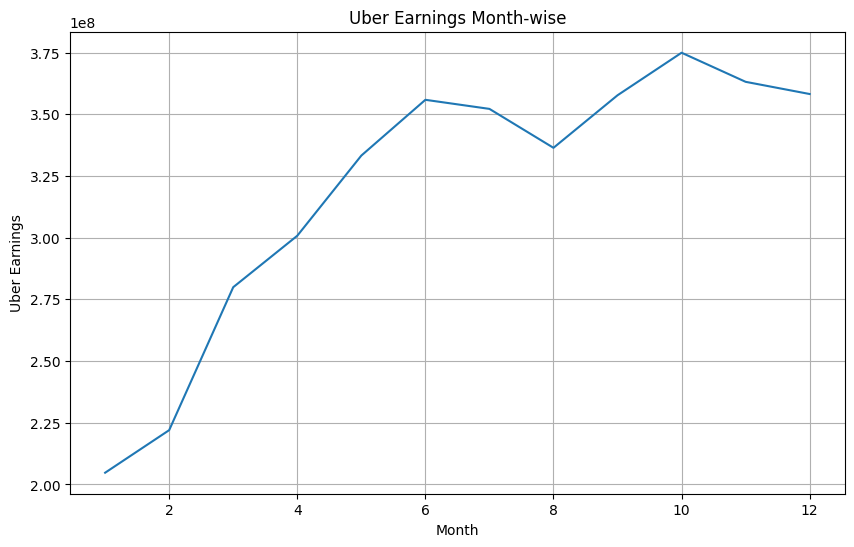

In [0]:
# Calculating Uber earnings month-wise
monthly_earnings_df = df.groupBy(month("request_datetime").alias("month")) \
                        .agg({"base_passenger_fare": "sum"}) \
                        .withColumnRenamed("sum(base_passenger_fare)", "uber_earnings") \
                        .orderBy("month")

# Converting the monthly_earnings_df DataFrame to Pandas for visualization
pandas_monthly_earnings_df = monthly_earnings_df.toPandas()


plt.figure(figsize=(10, 6))
plt.plot(pandas_monthly_earnings_df["month"], pandas_monthly_earnings_df["uber_earnings"])
plt.xlabel("Month")
plt.ylabel("Uber Earnings")
plt.title("Uber Earnings Month-wise")
plt.grid(True)
plt.show()


#Basewise sales

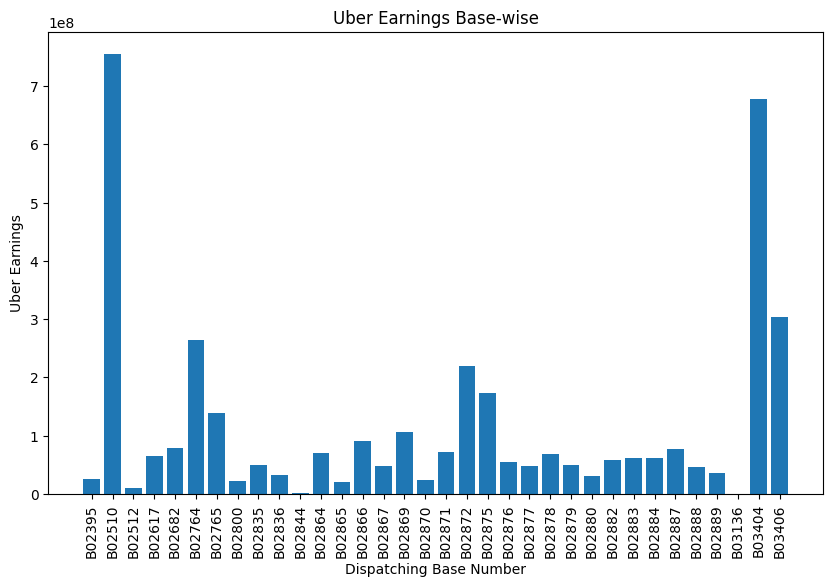

In [0]:
# Calculating Uber earnings base-wise
base_earnings_df = df.groupBy("dispatching_base_num") \
                     .agg({"base_passenger_fare": "sum"}) \
                     .withColumnRenamed("sum(base_passenger_fare)", "uber_earnings") \
                     .orderBy("dispatching_base_num")


pandas_base_earnings_df = base_earnings_df.toPandas()

plt.figure(figsize=(10, 6))

# Plotting the bar graph
plt.bar(pandas_base_earnings_df["dispatching_base_num"], pandas_base_earnings_df["uber_earnings"])
plt.xlabel("Dispatching Base Number")
plt.ylabel("Uber Earnings")
plt.title("Uber Earnings Base-wise")
plt.xticks(rotation=90)
plt.show()

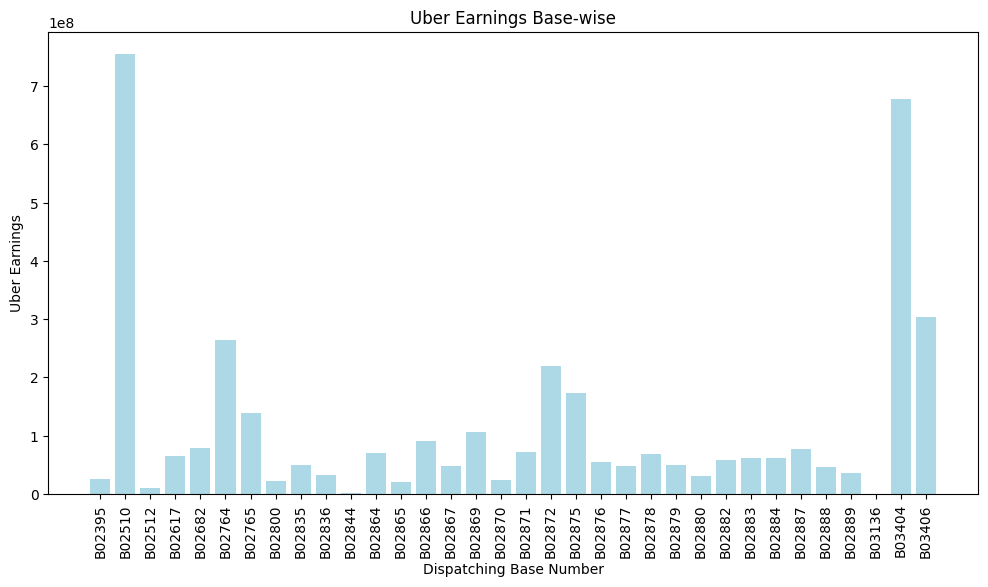

In [0]:
# Calculating Uber earnings base-wise
base_earnings_df = df.groupBy("dispatching_base_num") \
                     .agg({"base_passenger_fare": "sum"}) \
                     .withColumnRenamed("sum(base_passenger_fare)", "uber_earnings") \
                     .orderBy("dispatching_base_num")

pandas_base_earnings_df = base_earnings_df.toPandas()
plt.figure(figsize=(12, 6))
color = 'lightblue'

# Plotting the bar graph
plt.bar(pandas_base_earnings_df["dispatching_base_num"], pandas_base_earnings_df["uber_earnings"], color=color)
plt.xlabel("Dispatching Base Number")
plt.ylabel("Uber Earnings")
plt.title("Uber Earnings Base-wise")
plt.xticks(rotation=90)
plt.show()